# Introduction

In [77]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
# from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold

# Feature Exploration, Engineering and Cleaning

In [78]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### feauture engineering

In [79]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)

    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [80]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

## Visualisations

In [81]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


### Pearson Correlation Heatmap

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

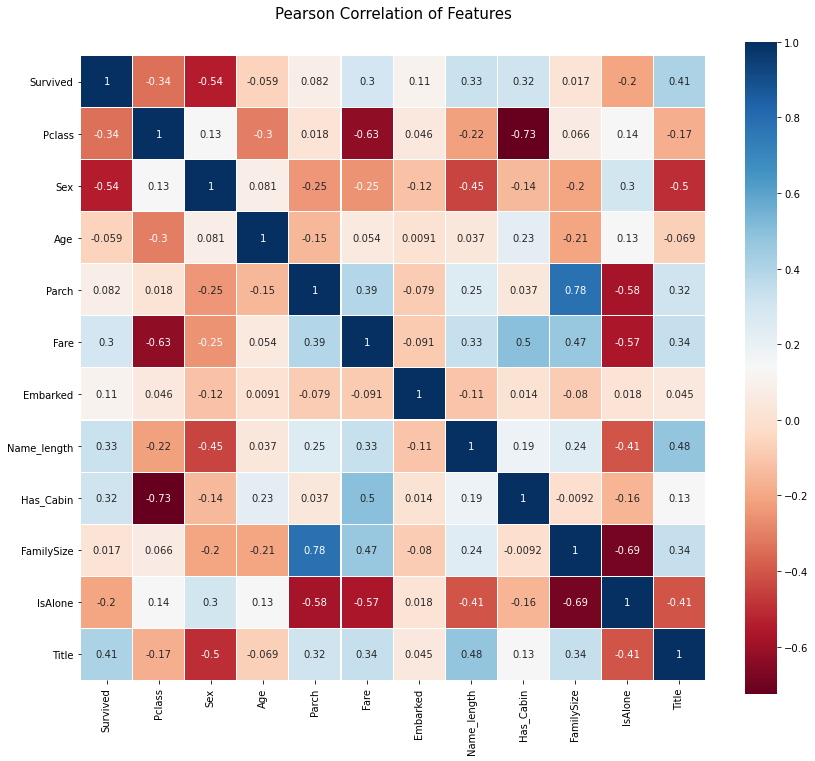

In [82]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

- 강한 상관관계를 가진 feature들이 많지 않음
- 가장 상관관계가 있는 두 가지 특징은 FamilySize와 Parch(부모/자녀)

### Pairplots

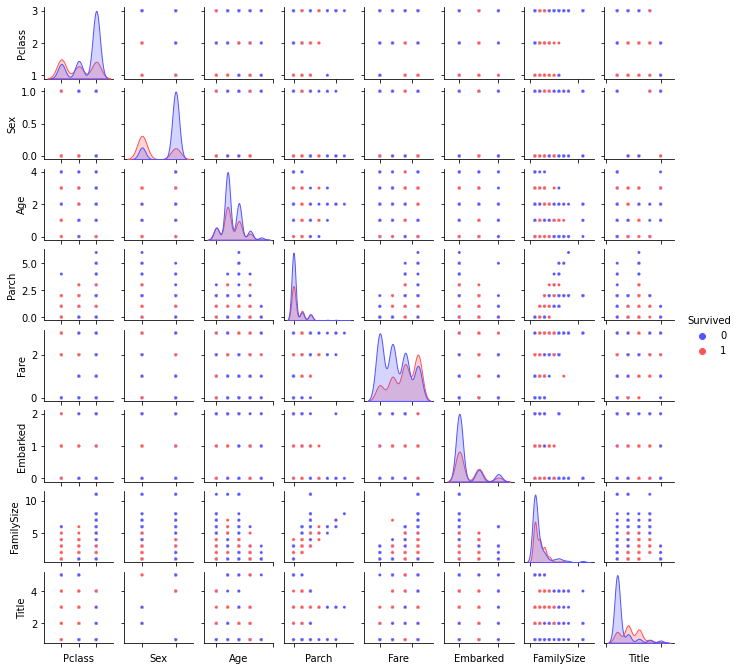

In [83]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
g.set(xticklabels=[])

# Ensembling & Stacking models

In [84]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
# kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
kf = KFold(n_splits=NFOLDS)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [85]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):  
        # for i, (train_index, test_index) in enumerate(kf) 에서 KFold 오류 해결하기 위해서 kf.split(x_train)로 변경
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generating our Base First-Level Models

1. Random Forest classifier
2. Extra Trees classifier
3. Adaboost classifer
4. Gradient Boosting classfier
5. Support Vector Machine

In [86]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025}

In [87]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [88]:
y_train = train['Survived'].ravel()  # ravel : 다차원 배열(array)을 1차원 배열로 평평하게 펴주는 함수
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values 

In [89]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)  # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test)  # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)  # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test)  # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test)  # Support Vector Classifier

print("Training is complete")

Training is complete


In [90]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12590419 0.19596897 0.03042172 0.02068077 0.072607   0.02390589
 0.10942991 0.06410903 0.06835823 0.01341015 0.27520415]
[0.11797933 0.37849509 0.02731044 0.01719415 0.05631672 0.02887356
 0.04804852 0.08408402 0.04683289 0.02145322 0.17341208]
[0.028 0.012 0.02  0.06  0.036 0.01  0.698 0.012 0.052 0.002 0.07 ]
[0.08421876 0.01444765 0.04995177 0.01397907 0.05236745 0.02225592
 0.17327151 0.03812561 0.112089   0.0060674  0.43322586]


- Feature Importance를 완전히 저장하는 방법을 알아내지 못해서 위의 코드에서 값을 인쇄한 다음 파이썬 목록에 붙여넣음

In [92]:
rf_features = [0.12590419, 0.19596897, 0.03042172, 0.02068077, 0.072607, 0.02390589,
               0.10942991, 0.06410903, 0.06835823, 0.01341015, 0.27520415]
et_features = [0.11797933, 0.37849509, 0.02731044, 0.01719415, 0.05631672, 0.02887356,
               0.04804852, 0.08408402, 0.04683289, 0.02145322, 0.17341208]
ada_features = [0.028, 0.012, 0.02, 0.06, 0.036, 0.01, 0.698, 0.012, 0.052, 0.002, 0.07]
gb_features = [0.08421876, 0.01444765, 0.04995177, 0.01397907, 0.05236745, 0.02225592,
               0.17327151, 0.03812561, 0.112089, 0.0060674, 0.43322586]

In [93]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features})

In [95]:
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.125904,0.117979,0.028,0.084219
1,Sex,0.195969,0.378495,0.012,0.014448
2,Age,0.030422,0.027310,0.020,0.049952
3,Parch,0.020681,0.017194,0.060,0.013979
4,Fare,0.072607,0.056317,0.036,0.052367


### 산점도를 통한 Feature Importance

In [97]:
# Random Forest
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text = feature_dataframe['features'].values)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2),
    showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


# Extra Trees
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text = feature_dataframe['features'].values)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2),
    showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


# AdaBoost
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text = feature_dataframe['features'].values)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2),
    showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


# Gradient Boosting
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text = feature_dataframe['features'].values)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2),
    showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [98]:
# 모든 feature importance의 평균을 계산하고 새로운 열로 저장
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.125904,0.117979,0.028,0.084219,0.089026
1,Sex,0.195969,0.378495,0.012,0.014448,0.150228
2,Age,0.030422,0.027310,0.020,0.049952,0.031921


### Feature Importance 평균 막대그래프

In [99]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(x= x,
               y= y,
               width=0.5,
               marker=dict(
                   color=feature_dataframe['mean'].values,
                   colorscale='Portland',
                   showscale=True,
                   reversescale = False),
               opacity=0.6)]

layout = go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2),
    showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output

In [100]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
                                        'ExtraTrees': et_oof_train.ravel(),
                                        'AdaBoost': ada_oof_train.ravel(),
                                        'GradientBoost': gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

In [101]:
data = [go.Heatmap(z=base_predictions_train.astype(float).corr().values ,
                   x=base_predictions_train.columns.values,
                   y=base_predictions_train.columns.values,
                   colorscale='Viridis',
                   showscale=True,
                   reversescale = True)]
py.iplot(data, filename='labelled-heatmap')

In [102]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

### Second level learning model via XGBoost

In [103]:
gbm = xgb.XGBClassifier(
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

### Producing the Submission file

In [104]:
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)